# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

## Setup

In [113]:
# All import statements needed for the project, for example:

import json
import pathlib
import urllib.parse
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin
import pandas as pd
import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db
import psycopg2

from shapely import wkt
from sqlalchemy import create_engine
from geoalchemy2 import WKTElement, Geometry
from sqlalchemy.orm import declarative_base

In [318]:
#!pip install GeoAlchemy2

In [2]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "UydgE9GUfZyuG9IpbKml1aKct"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "IE4501_Project_DB"
DB_USER = "postgres"
DB_URL = f"postgresql+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [3]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

In [11]:
def load_and_clean_zipcodes(zipcode_datafile):
     # Load the data using geopandas
    gdf_zip = gpd.read_file(ZIPCODE_DATA_FILE)
    
    # Drop unnecessary columns. Here, you need to decide which columns are relevant
    # For example, if you only need the zipcode and geometry, you can drop the rest
    columns_to_keep = ['ZIPCODE', 'geometry']
    gdf_zip = gdf_zip[columns_to_keep]

    # Remove invalid data points
    # This depends on what you define as invalid. As an example, you might want to remove rows with missing values
    gdf_zip = gdf_zip.dropna()
    gdf_zip = gdf_zip.drop_duplicates(subset = 'ZIPCODE')
    gdf_zip = gdf_zip.to_crs(4326)
    gdf_zip['longitude'] = gdf_zip.centroid.x
    gdf_zip['latitude'] = gdf_zip.centroid.y

    # Normalize column names
    # If you want to make column names lowercase for consistency
    gdf_zip.columns = [col.lower() for col in gdf_zip.columns]

    # Normalize data types if needed
    # For example, ensuring ZIPCODE is a string, not a number
    #gdf_zip['geometry'] = gdf_zip['geometry'].astype(str)

    # Additional cleaning steps can be added here depending on your specific requirements

    return gdf_zip
    #raise NotImplementedError()

In [12]:
#load_and_clean_zipcodes(ZIPCODE_DATA_FILE)

geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)

/var/folders/0h/g9zsw1191fl05wqh_8_l7p_w0000gn/T/ipykernel_52171/2287771014.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_zip['longitude'] = gdf_zip.centroid.x
/var/folders/0h/g9zsw1191fl05wqh_8_l7p_w0000gn/T/ipykernel_52171/2287771014.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_zip['latitude'] = gdf_zip.centroid.y


In [9]:
def download_and_clean_311_data():
    import requests

# Your Application Token
    app_token = 'UydgE9GUfZyuG9IpbKml1aKct'

# API endpoints for 311 and tree data
    api_endpoint_311_22 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                     "$select= created_date,incident_zip,complaint_type,latitude,longitude&"\
                     "$where= created_date between '2022-10-01' and'2023-09-30'&$limit=50000000&"\
                     f"$$app_token={app_token}"
    api_endpoint_311_21 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                     "$select= created_date,incident_zip,complaint_type,latitude,longitude&"\
                     "$where= created_date between '2021-10-01' and'2022-09-30'&$limit=50000000&"\
                     f"$$app_token={app_token}"
    api_endpoint_311_20 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                     "$select= created_date,incident_zip,complaint_type,latitude,longitude&"\
                     "$where= created_date between '2020-10-01' and'2021-09-30'&$limit=50000000&"\
                     f"$$app_token={app_token}"
    api_endpoint_311_19 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                     "$select= created_date,incident_zip,complaint_type,latitude,longitude&"\
                     "$where= created_date between '2019-10-01' and'2020-09-30'&$limit=50000000&"\
                     f"$$app_token={app_token}"
    api_endpoint_311_18 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                     "$select= created_date,incident_zip,complaint_type,latitude,longitude&"\
                     "$where= created_date between '2018-10-01' and'2019-09-30'&$limit=50000000&"\
                     f"$$app_token={app_token}"
    #api_endpoint_311 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$limit=5000'


# Headers for authentication
    #headers = {
        #'X-App-Token': app_token
    #}

# Make a GET request to the 311 data endpoint
    response_311_22 = requests.get(api_endpoint_311_22)
    response_311_21 = requests.get(api_endpoint_311_21)
    response_311_20 = requests.get(api_endpoint_311_20)
    response_311_19 = requests.get(api_endpoint_311_19)
    response_311_18 = requests.get(api_endpoint_311_18)
    

# Assuming you have loaded data into DataFrame
    df22 = gpd.read_file(response_311_22.text)
    df21 = gpd.read_file(response_311_21.text)
    df20 = gpd.read_file(response_311_20.text)
    df19 = gpd.read_file(response_311_19.text)
    df18 = gpd.read_file(response_311_18.text)  # Example for 311 data

# Removing unnecessary columns
    df = pd.concat([df22, df21,df20, df19, df18], axis=0, ignore_index=True)
    columns_to_keep = ['created_date', 'incident_zip', 'latitude','longitude', 'complaint_type']  # replace with actual column names
    df = df[columns_to_keep]

# Remove invalid data points
    #df = df[df[':@computed_region_efsh_h5xi'] != null] 
    df = df.dropna()# Replace with your criteria

# Normalize column names
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Convert data types
    #df['date_column'] = pd.to_datetime(df['date_column'])
   # df['numeric_column'] = pd.to_numeric(df['numeric_column'], errors='coerce')

# For geospatial data
    gdf_311 = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    gdf_311.set_crs("EPSG:4326", inplace=True)  # Replace with current SRID
    return gdf_311
    sampled_df = df.sample(n=10)  # Replace 100 with the number of samples you need
    print(sampled_df)


In [13]:
def download_and_clean_tree_data():
    app_token = 'UydgE9GUfZyuG9IpbKml1aKct'
    api_endpoint_tree = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_TREES}?"\
                      "$select=tree_id,latitude,longitude,zipcode,health,spc_common,status&"\
                      f"$$app_token={NYC_DATA_APP_TOKEN}&$limit=6500000"
    response_tree = requests.get(api_endpoint_tree)
    df2 = gpd.read_file(response_tree.text)
    columns_to_keep = ['tree_id', 'latitude','longitude', 'health', 'status', 'zipcode','spc_common']  # replace with actual column names
    df2 = df2[columns_to_keep]
    df2 = df2.dropna()
    df2.columns = [col.lower().replace(' ', '_') for col in df2.columns]
    gdf_tree = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude.astype(float), df2.latitude.astype(float)))
    gdf_tree.set_crs("EPSG:4326", inplace=True)
    return gdf_tree
    sample_tree = gdf.sample(n=10)
    print(sample_tree)
    

In [14]:
geodf_tree_data = download_and_clean_tree_data()

In [15]:
def load_and_clean_zillow_data():
   # Load the data using pandas, as we need to handle both non-spatial and spatial data
    df_zillow = pd.read_csv(ZILLOW_DATA_FILE)

    # Keep only the necessary columns
    columns_to_keep = ["RegionID", "SizeRank", "RegionName", "City", "CountyName", "2023-01-31", "2023-08-31", "2023-09-30"]
    df_zillow = df_zillow[columns_to_keep]

    # Remove rows with missing values in any of the columns
    df_zillow = df_zillow.dropna()
    df_zillow = df_zillow[df_zillow['City']=='New York']

    # Normalize column names to lowercase
    df_zillow.columns = [col.lower() for col in df_zillow.columns]

    # Normalize data types
    # Assuming 'RegionID' and 'SizeRank' should be integers, and dates should be in datetime format
    df_zillow['regionid'] = df_zillow['regionid'].astype(int)
    df_zillow['sizerank'] = df_zillow['sizerank'].astype(int)


    # Convert DataFrame to GeoDataFrame
    gdf_zillow = gpd.GeoDataFrame(df_zillow)

    # Normalize SRID of any geometry if present
    # Example: gdf.set_crs(epsg=YOUR_EPSG_CODE, inplace=True)

    return gdf_zillow

In [16]:
df_zillow_data = load_and_clean_zillow_data()

In [436]:

#geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
#geodf_311_data = download_and_clean_311_data()
#geodf_tree_data = download_and_clean_tree_data()
#df_zillow_data = load_and_clean_zillow_data()


/var/folders/0h/g9zsw1191fl05wqh_8_l7p_w0000gn/T/ipykernel_43282/2287771014.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_zip['longitude'] = gdf_zip.centroid.x
/var/folders/0h/g9zsw1191fl05wqh_8_l7p_w0000gn/T/ipykernel_43282/2287771014.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_zip['latitude'] = gdf_zip.centroid.y


In [10]:
geodf_311_data = download_and_clean_311_data()
geodf_311_data

,created_date,incident_zip,latitude,longitude,complaint_type,geometry
0,2023-09-30 00:00:00,10003,40.7348900594353,-73.98994355524363,Food Poisoning,POINT (-73.98994 40.73489)
1,2023-09-29 23:59:53,11433,40.696276248515204,-73.79372227601002,Noise - Residential,POINT (-73.79372 40.69628)
2,2023-09-29 23:59:40,10002,40.723202995922456,-73.99124770125584,For Hire Vehicle Complaint,POINT (-73.99125 40.72320)
3,2023-09-29 23:59:10,11216,40.6805991000235,-73.93848100682325,Noise - Residential,POINT (-73.93848 40.68060)
4,2023-09-29 23:59:00,10002,40.723202995922456,-73.99124770125584,For Hire Vehicle Complaint,POINT (-73.99125 40.72320)
...,...,...,...,...,...,...
14988283,2018-10-01 00:00:00,11237,40.70419450639702,-73.91857921139756,Rodent,POINT (-73.91858 40.70419)
14988284,2018-10-01 00:00:00,10463,40.885270925902645,-73.89916465554923,Rodent,POINT (-73.89916 40.88527)
14988285,2018-10-01 00:00:00,11203,40.64876828032588,-73.92522717814309,Unsanitary Animal Pvt Property,POINT (-73.92523 40.64877)
14988286,2018-10-01 00:00:00,11238,40.67358844926164,-73.96295477409771,Rodent,POINT (-73.96295 40.67359)


In [17]:
print(type(geodf_311_data))
print(type(geodf_tree_data))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [18]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 248 entries, 0 to 262
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   zipcode    248 non-null    object  
 1   geometry   248 non-null    geometry
 2   longitude  248 non-null    float64 
 3   latitude   248 non-null    float64 
dtypes: float64(2), geometry(1), object(1)
memory usage: 9.7+ KB


In [19]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

,zipcode,geometry,longitude,latitude
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",-73.796503,40.675872
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679...",-73.936327,40.671156
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668...",-73.913077,40.662813
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670...",-73.953960,40.663115
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650...",-73.976451,40.643320


In [20]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 14501348 entries, 0 to 14988287
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   created_date    datetime64[ns]
 1   incident_zip    object        
 2   latitude        object        
 3   longitude       object        
 4   complaint_type  object        
 5   geometry        geometry      
dtypes: datetime64[ns](1), geometry(1), object(4)
memory usage: 774.5+ MB


In [21]:
geodf_311_data.head()

,created_date,incident_zip,latitude,longitude,complaint_type,geometry
0,2023-09-30 00:00:00,10003,40.7348900594353,-73.98994355524363,Food Poisoning,POINT (-73.98994 40.73489)
1,2023-09-29 23:59:53,11433,40.696276248515204,-73.79372227601002,Noise - Residential,POINT (-73.79372 40.69628)
2,2023-09-29 23:59:40,10002,40.723202995922456,-73.99124770125584,For Hire Vehicle Complaint,POINT (-73.99125 40.72320)
3,2023-09-29 23:59:10,11216,40.6805991000235,-73.93848100682325,Noise - Residential,POINT (-73.93848 40.68060)
4,2023-09-29 23:59:00,10002,40.723202995922456,-73.99124770125584,For Hire Vehicle Complaint,POINT (-73.99125 40.72320)


In [22]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 652167 entries, 0 to 683787
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   tree_id     652167 non-null  object  
 1   latitude    652167 non-null  object  
 2   longitude   652167 non-null  object  
 3   health      652167 non-null  object  
 4   status      652167 non-null  object  
 5   zipcode     652167 non-null  object  
 6   spc_common  652167 non-null  object  
 7   geometry    652167 non-null  geometry
dtypes: geometry(1), object(7)
memory usage: 44.8+ MB


In [24]:
geodf_tree_data.head()

,tree_id,latitude,longitude,health,status,zipcode,spc_common,geometry
0,180683,40.72309177,-73.84421522,Fair,Alive,11375,red maple,POINT (-73.84422 40.72309)
1,200540,40.79411067,-73.81867946,Fair,Alive,11357,pin oak,POINT (-73.81868 40.79411)
2,204026,40.71758074,-73.9366077,Good,Alive,11211,honeylocust,POINT (-73.93661 40.71758)
3,204337,40.71353749,-73.93445616,Good,Alive,11211,honeylocust,POINT (-73.93446 40.71354)
4,189565,40.66677776,-73.97597938,Good,Alive,11215,American linden,POINT (-73.97598 40.66678)


In [25]:
df_zillow_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 121 entries, 4 to 6721
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   regionid    121 non-null    int64  
 1   sizerank    121 non-null    int64  
 2   regionname  121 non-null    int64  
 3   city        121 non-null    object 
 4   countyname  121 non-null    object 
 5   2023-01-31  121 non-null    float64
 6   2023-08-31  121 non-null    float64
 7   2023-09-30  121 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 8.5+ KB


In [26]:
df_zillow_data.head()

,regionid,sizerank,regionname,city,countyname,2023-01-31,2023-08-31,2023-09-30
4,62093,7,11385,New York,Queens County,2895.699421,3064.476503,3079.585783
6,62019,9,11208,New York,Kings County,2588.030194,2737.547470,2728.733333
13,61807,17,10467,New York,Bronx County,2155.617718,2353.686402,2423.888889
14,62085,18,11373,New York,Queens County,2255.604528,2302.557354,2292.994444
15,62037,19,11226,New York,Kings County,2680.683700,2785.320137,2762.435713


## Part 2: Storing Data

In [27]:
!createdb IE4501_Project_DB

createdb: error: database creation failed: ERROR:  database "IE4501_Project_DB" already exists


In [28]:
!psql --dbname IE4501_Project_DB -c 'CREATE EXTENSION postgis;'

ERROR:  extension "postgis" already exists


In [29]:
engine = db.create_engine(DB_URL)

### Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

In [343]:
engine = db.create_engine(DB_URL)

#### Option 1: SQL

In [30]:
# if using SQL (as opposed to SQLAlchemy), define the SQL statements to create your 4 tables
ZIPCODE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS geodf_zipcode_data (
        id SERIAL PRIMARY KEY,
        zipcode VARCHAR(10),
        geometry GEOMETRY,
        longitude FLOAT,
        latitude FLOAT
    );
    """

NYC_311_SCHEMA = """
    CREATE TABLE IF NOT EXISTS geodf_311_data (
        id SERIAL PRIMARY KEY,
        created_date DATE,
        incident_zip VARCHAR(10),
        complaint_type VARCHAR(100),
        latitude FLOAT,
        longitude FLOAT,
        geometry GEOMETRY
    );
    """

NYC_TREE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS geodf_tree_data (
        id SERIAL PRIMARY KEY,
        tree_id INTEGER,
        latitude FLOAT,
        longitude FLOAT,
        zipcode VARCHAR(10),
        health VARCHAR(100),
        status VARCHAR(100),
        spc_common VARCHAR(100),
        geometry GEOMETRY
    );
    """

ZILLOW_SCHEMA = """
    CREATE TABLE IF NOT EXISTS df_zillow_data (
        RegionID INTEGER PRIMARY KEY,
        SizeRank INT,
        RegionName VARCHAR(10),
        City VARCHAR(100),
        CountyName VARCHAR(100),
        "2023-01-31" FLOAT,
        "2023-08-31" FLOAT,
        "2023-09-30" FLOAT
    );
    """

In [31]:
# create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

In [32]:
conn = psycopg2.connect("dbname='IE4501_Project_DB' user='postgres'")
#conn.autocommit = True
cursor = conn.cursor()

In [33]:
# If using SQL (as opposed to SQLAlchemy), execute the schema files to create tables
with cursor:
    cursor.execute(ZIPCODE_SCHEMA)
    cursor.execute(NYC_311_SCHEMA)
    cursor.execute(NYC_TREE_SCHEMA)
    cursor.execute(ZILLOW_SCHEMA)
conn.commit()

#### Option 2: SQLAlchemy

In [348]:
Base = declarative_base()

class Tree(Base):
    __tablename__ = "trees"

    ...


ArgumentError: Mapper Mapper[Tree(trees)] could not assemble any primary key columns for mapped table 'trees'

In [ ]:
Base.metadata.create_all(engine)

### Add Data to Database

These are just a couple of options to write data to your tables; you can use one or the other, a different method, or a combination.

#### Option 1: SQL

In [437]:

#engine.dispose()

In [34]:
def write_dataframes_to_table(tablename_to_dataframe):
    # write INSERT statements or use pandas/geopandas to write SQL
    engine = create_engine(DB_URL)
    #for tablename, dataframe in tablename_to_dataframe.items():
    # Iterate over the dictionary and write each dataframe to its respective table
        #if 'geometry' in dataframe.columns:
                # Convert geometry to WKTElement
                #dataframe['geometry'] = dataframe['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))

            # Write the dataframe to the SQL table
        #dataframe.to_sql(tablename, engine, if_exists='append', index=False, dtype={'geometry': Geometry('GEOMETRY', srid=4326)})

    # Close the engine connection
    
    for tablename, dataframe in tablename_to_dataframe.items():
        if 'geometry' in dataframe.columns:
            # Ensure the column is in the correct format
            dataframe['geometry'] = dataframe['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326))
            #dataframe.drop('geometry',axis=1,inplace=True)
            dataframe.to_sql(tablename, engine, if_exists='replace', index=False, dtype={'geometry': Geometry('GEOMETRY', srid=4326)})
        else: 
            dataframe.to_sql(tablename, engine, if_exists='replace', index = False)
    #engine.dispose()
    #for tablename, dataframe in tablename_to_dataframe.items():
        #if 'geometry' in dataframe.columns:
            # Convert string representations of geometries to geometry objects
            #if isinstance(dataframe.iloc[0]['geometry'], str):
                #dataframe['geometry'] = dataframe['geometry'].apply(wkt.loads)

            # Convert geometry to WKTElement
            #dataframe['geometry'] = dataframe['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))

        # Write the dataframe to the SQL table
        #dataframe.to_sql(tablename, engine, if_exists='replace', index=False, dtype={'geometry': Geometry('GEOMETRY', srid=4326)})
    
    #engine.dispose()
    #for tablename, dataframe in tablename_to_dataframe.items():
        # Convert GeoDataFrame to WKB format
        #if not isinstance(dataframe, gpd.GeoDataFrame):
           # dataframe['geometry'] = dataframe['geometry'].apply(lambda x: x.to_wkb())
        
        # Write the dataframe to the SQL table
#dataframe.to_sql(tablename, engine, if_exists='replace', index=False)
    
    #engine.dispose()

In [35]:
tablename_to_dataframe = {
    "geodf_zipcode_data": geodf_zipcode_data,
    "geodf_311_data": geodf_311_data,
    "geodf_tree_data": geodf_tree_data,
    "df_zillow_data": df_zillow_data,
}

In [36]:
write_dataframes_to_table(tablename_to_dataframe)

/var/folders/0h/g9zsw1191fl05wqh_8_l7p_w0000gn/T/ipykernel_52171/1907954417.py:18: UserWarning: Geometry column does not contain geometry.
  dataframe['geometry'] = dataframe['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326))
/var/folders/0h/g9zsw1191fl05wqh_8_l7p_w0000gn/T/ipykernel_52171/1907954417.py:18: UserWarning: Geometry column does not contain geometry.
  dataframe['geometry'] = dataframe['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326))
/var/folders/0h/g9zsw1191fl05wqh_8_l7p_w0000gn/T/ipykernel_52171/1907954417.py:18: UserWarning: Geometry column does not contain geometry.
  dataframe['geometry'] = dataframe['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326))


In [37]:
queries = {
    'geodf_zipcode_data': 'SELECT * FROM geodf_zipcode_data LIMIT 5;',
    'geodf_311_data': 'SELECT * FROM geodf_311_data LIMIT 5;',
    'geodf_tree_data': 'SELECT * FROM geodf_tree_data LIMIT 5;',
    'df_zillow_data': 'SELECT * FROM df_zillow_data LIMIT 5;'
}

# Execute queries and display the first few rows of each table
for table_name, query in queries.items():
    df = pd.read_sql_query(query, engine)
    print(f"Data from {table_name}:\n", df, "\n")

Data from geodf_zipcode_data:
   zipcode                                           geometry  longitude  \
0   11436  0103000020E6100000010000009F0000002BFF7C059373... -73.796503   
1   11213  0103000020E610000001000000A2000000FB8CA252FE7B... -73.936327   
2   10009  0103000020E610000001000000A60000006853AC1F4D7E... -73.979156   
3   11212  0103000020E6100000010000001A01000024C269CAC979... -73.913077   
4   11225  0103000020E610000001000000A0000000DAA0A86E4F7D... -73.953960   

    latitude  
0  40.675872  
1  40.671156  
2  40.726533  
3  40.662813  
4  40.663115   

Data from geodf_311_data:
          created_date incident_zip            latitude           longitude  \
0 2023-09-30 00:00:00        10003    40.7348900594353  -73.98994355524363   
1 2023-09-29 23:59:53        11433  40.696276248515204  -73.79372227601002   
2 2023-09-29 23:59:40        10002  40.723202995922456  -73.99124770125584   
3 2023-09-29 23:59:10        11216    40.6805991000235  -73.93848100682325   
4 2023-09

#### Option 2: SQLAlchemy

In [ ]:
Session = db.orm.sessionmaker(bind=engine)
session = Session()

In [ ]:
for row in geodf_tree_data.iterrows():
    tree = Tree(...)
    session.add(tree)

NameError: name 'Tree' is not defined

In [ ]:
session.commit()

## Part 3: Understanding the Data

### Query 1

In [38]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, "w") as file:
        file.write(query)

In [39]:

QUERY_1 = """
SELECT incident_zip,
COUNT(*) AS complaint_count
FROM geodf_311_data
WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY incident_zip
ORDER BY complaint_count DESC;
"""

In [40]:
df_complaints_per_zipcode = pd.read_sql_query(QUERY_1, engine)
df_complaints_per_zipcode

,incident_zip,complaint_count
0,11226,49112
1,10467,47214
2,10468,43926
3,10452,43706
4,11385,43469
...,...,...
237,10175,1
238,10550,1
239,10080,1
240,29601,1


In [41]:
write_query_to_file(QUERY_1, 'Area_comfort_live.sql')

In [42]:
QUERY_2 = """
SELECT zipcode, COUNT(*) AS tree_count
FROM geodf_tree_data
GROUP BY zipcode
ORDER BY tree_count DESC
LIMIT 10;
"""

In [43]:
df_trees_per_zipcode = pd.read_sql(QUERY_2, engine)
df_trees_per_zipcode

,zipcode,tree_count
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9016
7,11207,8293
8,11208,7896
9,11434,7833


In [44]:
write_query_to_file(QUERY_2, 'top_10_zipcodes_by_trees.sql')

In [45]:
QUERY_3 = """
SELECT t.zipcode, TO_CHAR(AVG(z."2023-08-31"), 'FM9,999,999.00') AS average_rent
FROM (
    SELECT zipcode, COUNT(*) AS tree_count
    FROM geodf_tree_data
    GROUP BY zipcode
    ORDER BY tree_count DESC
    LIMIT 10
) AS t
JOIN df_zillow_data z ON t.zipcode::text = z.RegionName::text
GROUP BY t.zipcode, t.tree_count
ORDER BY t.tree_count DESC;
"""

In [46]:
df_average_rent_top_tree_areas = pd.read_sql_query(QUERY_3, engine)
df_average_rent_top_tree_areas

,zipcode,average_rent
0,10314,"2,465.47"
1,10306,"2,331.54"
2,10309,"1,832.01"
3,11234,"2,312.31"
4,11385,"3,064.48"
5,11357,"2,458.81"
6,11207,"3,079.09"
7,11208,"2,737.55"


In [47]:
write_query_to_file(QUERY_3, 'Affordability_place_most_trees.sql')

In [48]:
QUERY_4 = """
(SELECT z.RegionName AS zip_code, 
        TO_CHAR(AVG(z."2023-01-31"), 'FM9,999,999.00') AS average_rent,
        (SELECT COUNT(*) FROM geodf_tree_data t WHERE t.zipcode::text = z.RegionName::text) AS tree_count,
        (SELECT COUNT(*) FROM geodf_311_data c WHERE c.incident_zip::text = z.RegionName::text) AS complaint_count
 FROM df_zillow_data z
 GROUP BY z.RegionName
 ORDER BY AVG(z."2023-01-31") ASC
 LIMIT 5)

UNION

(SELECT z.RegionName AS zip_code, 
        TO_CHAR(AVG(z."2023-01-31"), 'FM9,999,999.00') AS average_rent,
        (SELECT COUNT(*) FROM geodf_tree_data t WHERE t.zipcode::text = z.RegionName::text) AS tree_count,
        (SELECT COUNT(*) FROM geodf_311_data c WHERE c.incident_zip::text = z.RegionName::text) AS complaint_count
 FROM df_zillow_data z
 GROUP BY z.RegionName
 ORDER BY AVG(z."2023-01-31") DESC
 LIMIT 5);
 """

In [49]:
df_rent_tree_complaints = pd.read_sql_query(QUERY_4, engine)
df_rent_tree_complaints

,zip_code,average_rent,tree_count,complaint_count
0,10013,"5,480.11",1132,56892
1,10282,"7,143.35",230,2746
2,10458,"1,883.08",3212,175995
3,10011,"4,741.87",2040,98470
4,10007,"7,270.24",338,18166
5,10309,"1,380.51",12105,51497
6,11357,"1,829.66",9016,64272
7,10453,"1,820.23",2874,179933
8,10462,"1,801.89",4048,131881
9,10069,"4,959.67",112,2553


In [50]:
write_query_to_file(QUERY_4, 'Average_rent.sql')

In [51]:
QUERY_5 = """
SELECT z.zipcode, COUNT(t.tree_id) AS tree_count
FROM geodf_tree_data t
JOIN geodf_zipcode_data z ON ST_Contains(z.geometry, t.geometry)
GROUP BY z.zipcode
ORDER BY tree_count DESC
LIMIT 10;
"""

In [52]:
df_trees_per_zipcode = pd.read_sql_query(QUERY_5, engine)
df_trees_per_zipcode

,zipcode,tree_count
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9016
7,11207,8294
8,11208,7897
9,11434,7833


In [53]:
write_query_to_file(QUERY_5, 'Most_Greenary.sql')

In [54]:
QUERY_6 = """
SELECT tree_id AS id, 
       spc_common AS species, 
       health, 
       status, 
       ST_AsText(geometry) AS coordinate_location
FROM geodf_tree_data t
WHERE ST_DWithin(
       t.geometry::geography,
       ST_SetSRID(ST_MakePoint(%(longitude)s, %(latitude)s), 4326)::geography, 
       %(radius)s
)
"""

In [55]:
# Ensure latitude and longitude are floats
latitude = 40.80737875669467
longitude = -73.96253174434912
radius = 0.5 *1609.34
# Execute the query and display the result
df_nearby_trees = pd.read_sql_query(QUERY_6, engine, params={'longitude': longitude, 'latitude': latitude, 'radius': radius})
df_nearby_trees


,id,species,health,status,coordinate_location
0,198514,pin oak,Good,Alive,POINT(-73.9620798 40.80230109)
1,209919,London planetree,Good,Alive,POINT(-73.96331506 40.80881155)
2,209921,London planetree,Good,Alive,POINT(-73.96340334 40.80874458)
3,203887,willow oak,Good,Alive,POINT(-73.96071917 40.80572583)
4,196440,American elm,Fair,Alive,POINT(-73.96412322 40.81114538)
...,...,...,...,...,...
2767,187144,pin oak,Good,Alive,POINT(-73.96190643 40.80582818)
2768,187101,pin oak,Good,Alive,POINT(-73.96249825 40.8050214)
2769,187102,pin oak,Fair,Alive,POINT(-73.96246303 40.80506933)
2770,203997,London planetree,Good,Alive,POINT(-73.96065411 40.80499024)


## Part 4: Visualizing the Data

### Visualization 1

In [56]:
# use a more descriptive name for your function
def plot_top_3_complaints(engine):
    # Get the data
    df = get_top_3_complaints_data(engine)

    # Create the plot
    plt.figure(figsize=(15, 7))
    for complaint_type in df['complaint_type'].unique():
        subset = df[df['complaint_type'] == complaint_type]
        plt.plot(subset['date'], subset['count'], label=complaint_type)

    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.title('Top 3 Complaint Types in NYC: Daily Complaint Counts')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [57]:
def get_top_3_complaints_data(engine):
    top_complaints_query = '''
    SELECT complaint_type, COUNT(*) as count
    FROM geodf_311_data
    WHERE created_date BETWEEN '2022-10-01' AND  '2023-10-01'
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT 3;
    '''
    top_complaints = pd.read_sql_query(top_complaints_query, engine)

    daily_complaints_query = '''
    SELECT DATE(created_date) as date, complaint_type, COUNT(*) as count
    FROM geodf_311_data
    WHERE 
        complaint_type IN %(top_complaints)s AND
        created_date BETWEEN '2022-10-01' AND '2023-10-01'
    GROUP BY date, complaint_type
    ORDER BY date;
    '''
    daily_counts = pd.read_sql_query(daily_complaints_query, engine, params={'top_complaints': tuple(top_complaints['complaint_type'])})

    return daily_counts


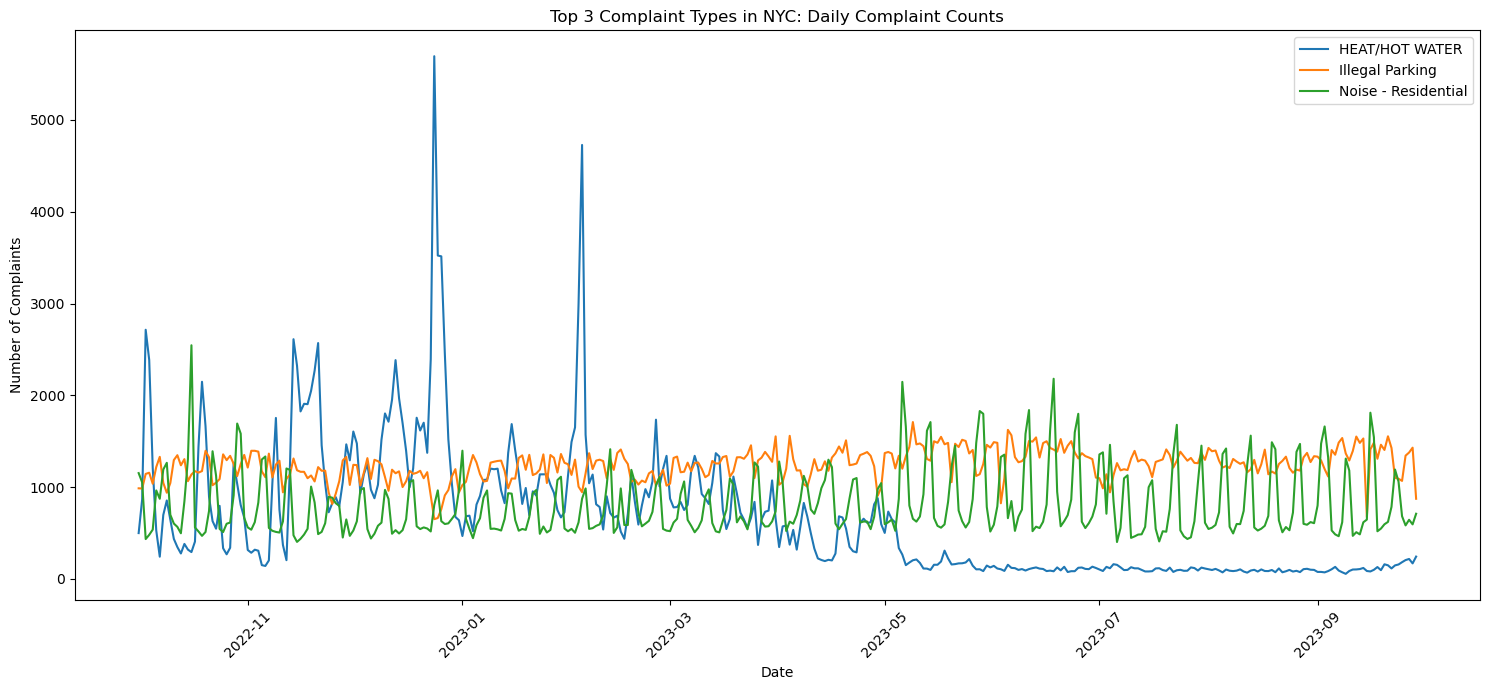

In [58]:
plot_top_3_complaints(engine)

Visualization 2

In [59]:
def get_top_10_complaints_data(engine, zip_code='10027', start_date='2018-10-01', end_date='2023-09-30'):
    # SQL Query to find top 10 complaint types in the given zip code and date range
    query = '''
    SELECT complaint_type, COUNT(*) as count
    FROM geodf_311_data
    WHERE incident_zip = %(zip_code)s AND
          created_date >= %(start_date)s AND
          created_date <= %(end_date)s
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT 10;
    '''
    return pd.read_sql_query(query, engine, params={'zip_code': zip_code, 'start_date': start_date, 'end_date': end_date})

In [60]:
def plot_top_10_complaints(engine):
    # Get the data
    df = get_top_10_complaints_data(engine)

    # Create the bar chart
    df.plot(kind='bar', x='complaint_type', y='count', figsize=(10, 6), legend=False)
    plt.xlabel('Complaint Type')
    plt.ylabel('Number of Complaints')
    plt.title('Top 10 Complaint Types in Zip Code 10027 (Oct 2018 - Sep 2023)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

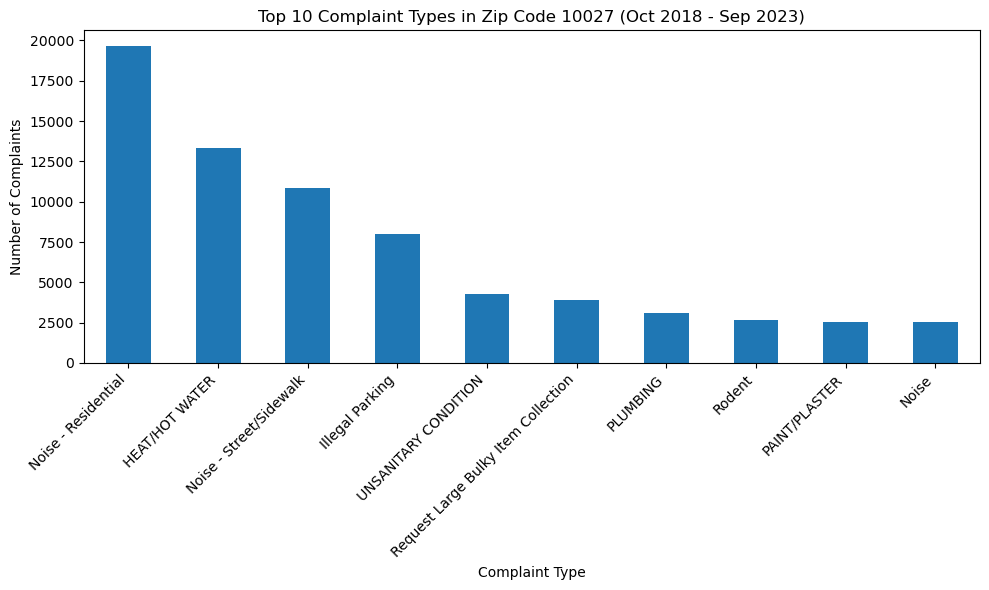

In [61]:
plot_top_10_complaints(engine)

Visualization 3

In [94]:
#get the average data of the rent within the date range
def get_average_rent_data(engine, start_date='2015-01-01', end_date='2023-09-30'):
    query = '''
    SELECT RegionName AS zipcode, AVG("2023-01-31") AS average_rent
    FROM df_zillow_data
    GROUP BY RegionName;
    '''
    df = pd.read_sql_query(query, engine)
    df['zipcode'] = df['zipcode'].astype(str) 
    return df

In [95]:
#count the numebr of trees
def get_tree_count_data(engine):
    query = '''
    SELECT zipcode, COUNT(*) AS tree_count
    FROM geodf_tree_data
    GROUP BY zipcode;
    '''
    df = pd.read_sql_query(query, engine)
    df['zipcode'] = df['zipcode'].astype(str) 
    return df

In [96]:
#get the data of complaint numbers
def get_complaint_count_data(engine, start_date='2015-01-01', end_date='2023-09-30'):
    query = '''
    SELECT incident_zip AS zipcode, COUNT(*) AS complaint_count
    FROM geodf_311_data
    WHERE created_date >= %(start_date)s AND created_date <= %(end_date)s
    GROUP BY incident_zip;
    '''
    df = pd.read_sql_query(query, engine, params={'start_date': start_date, 'end_date': end_date})
    df['zipcode'] = df['zipcode'].astype(str) 
    return df

In [97]:
def plot_rent_trees_complaints_correlation(engine):
    # Fetch data
    rent_data = get_average_rent_data(engine)
    tree_data = get_tree_count_data(engine)
    complaint_data = get_complaint_count_data(engine)

    # Merge datasets
    merged_data = rent_data.merge(tree_data, on='zipcode', how='outer').merge(complaint_data, on='zipcode', how='outer')

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Rent vs. Tree Count
    ax1.scatter(merged_data['average_rent'], merged_data['tree_count'], alpha=0.5)
    ax1.set_ylabel('Tree Count')
    ax1.set_title('Average Rent vs. Tree Count by Zip Code')

    # Rent vs. Complaint Count
    ax2.scatter(merged_data['average_rent'], merged_data['complaint_count'], alpha=0.5, color='red')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Complaint Count')
    ax2.set_title('Average Rent vs. Complaint Count by Zip Code')

    plt.tight_layout()
    plt.show()

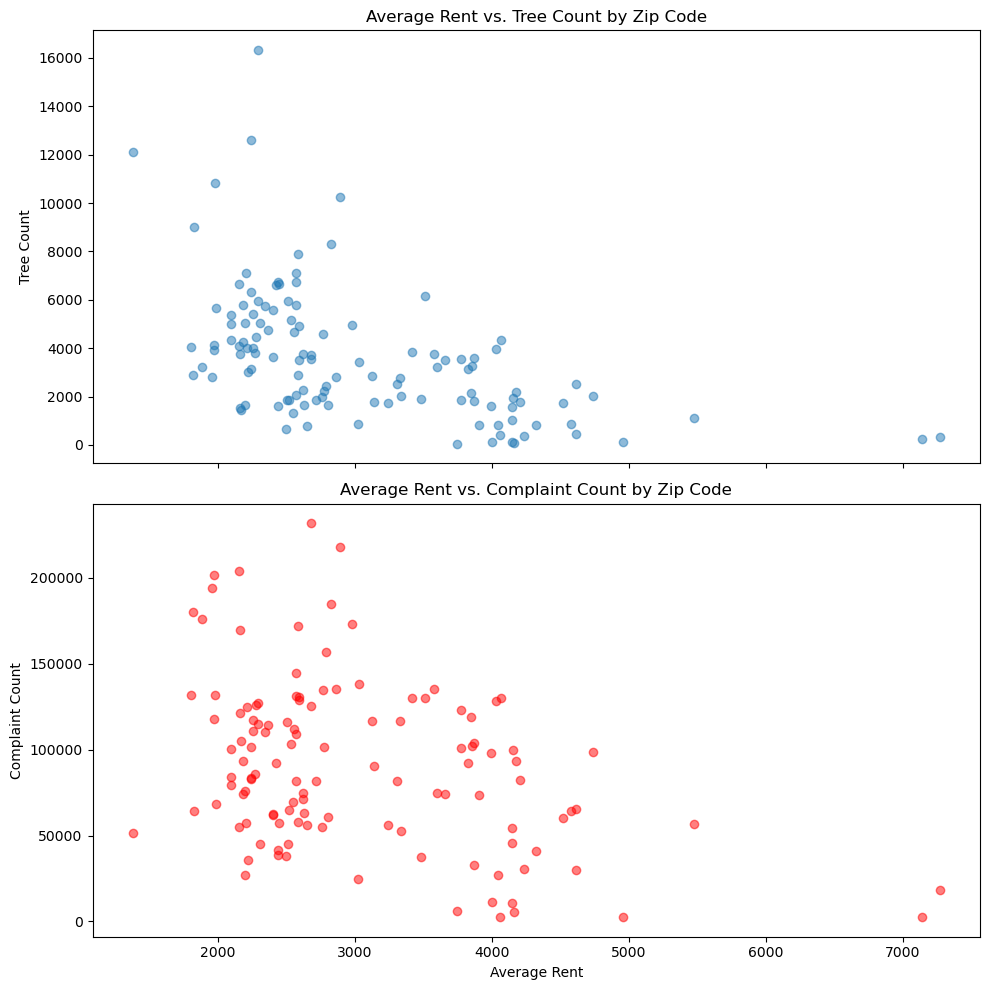

In [98]:
plot_rent_trees_complaints_correlation(engine)

Visualization 4

In [107]:
import numpy as np
#get the rent data
def get_rent_data(engine):
    query = '''
    SELECT RegionName AS zipcode, "2023-08-31" AS average_rent
    FROM df_zillow_data;
    '''
    df = pd.read_sql_query(query, engine)
    df['zipcode'] = df['zipcode'].astype(str) 
    return df

In [108]:
def get_complaints_data(engine):
    query = '''
    SELECT incident_zip AS zipcode, COUNT(*) AS complaint_count
    FROM geodf_311_data
    WHERE created_date >= '2022-10-01' AND created_date <= '2023-09-30'
    GROUP BY incident_zip;
    '''
    df = pd.read_sql_query(query, engine)
    df['zipcode'] = df['zipcode'].astype(str) 
    return df

In [111]:
def plot_rent_vs_complaints_boxplot(engine):
    rent_data = get_rent_data(engine)
    complaints_data = get_complaints_data(engine)

    merged_data = rent_data.merge(complaints_data, on='zipcode', how='inner')

    rent_bins = np.arange(0, merged_data['average_rent'].max() + 1000, 1000)
    merged_data['rent_bin'] = pd.cut(merged_data['average_rent'], bins=rent_bins)

    bin_labels = [f'{int(left)}-{int(right)}' for left, right in zip(rent_bins[:-1], rent_bins[1:])]

    plt.figure(figsize=(12, 6))
    plt.boxplot(
        [group['complaint_count'] for name, group in merged_data.groupby('rent_bin')],
        labels=bin_labels
    )
    plt.xlabel('Average Rent (Sept 2023) [$]')
    plt.ylabel('Number of 311 Complaints')
    plt.title('311 Complaints vs. Average Rent by Zip Code')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


/var/folders/0h/g9zsw1191fl05wqh_8_l7p_w0000gn/T/ipykernel_52171/2737554600.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  [group['complaint_count'] for name, group in merged_data.groupby('rent_bin')],


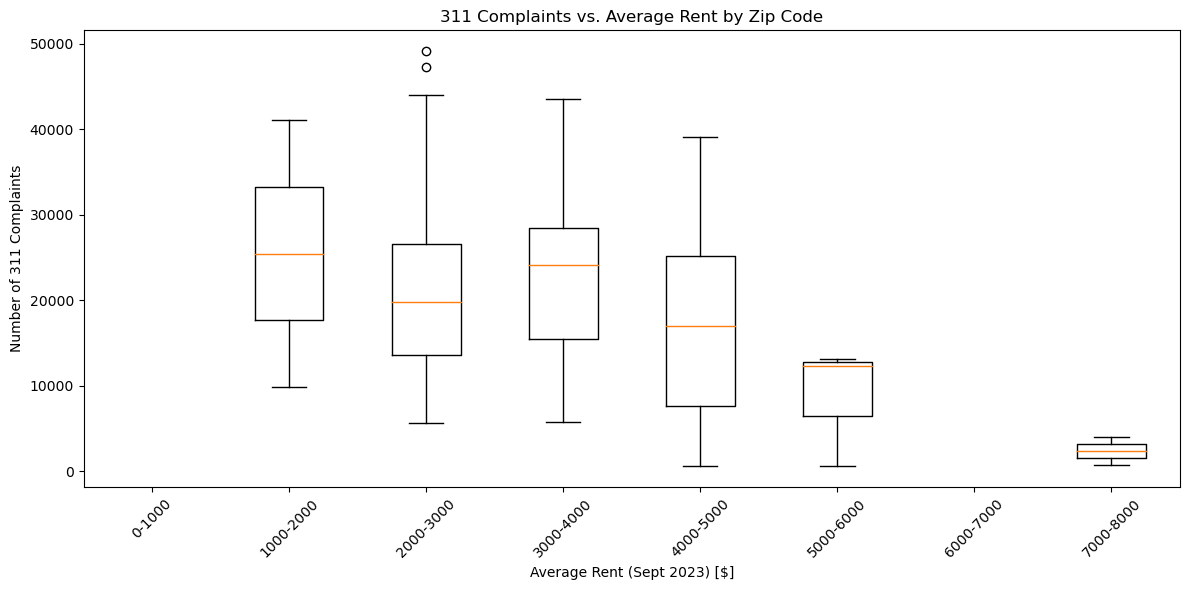

In [112]:
plot_rent_vs_complaints_boxplot(engine)

Visualization 5

In [117]:
def get_311_incidents_near_point(engine, latitude, longitude, radius_meters, start_date, end_date):
    query = '''
    SELECT incident_zip, latitude, longitude, created_date, ST_AsText(ST_SetSRID(ST_MakePoint(longitude::double precision, latitude::double precision), 4326)) AS geometry
    FROM geodf_311_data
    WHERE created_date >= %(start_date)s AND created_date <= %(end_date)s;
    '''
    df_311 = pd.read_sql_query(query, engine, params={'start_date': start_date, 'end_date': end_date})

#Convert
    df_311['geometry'] = df_311['geometry'].apply(wkt.loads)

    gdf_311 = gpd.GeoDataFrame(df_311, geometry='geometry')

    central_point = Point(longitude, latitude)
    buffer = central_point.buffer(radius_meters / 111.32)  # Approximate conversion of km to degrees

    incidents_within_buffer = gdf_311[gdf_311.within(buffer)]

    return incidents_within_buffer



In [118]:
def plot_311_incidents_near_point(engine, latitude, longitude, radius_meters, start_date, end_date):
    # Get the data
    incidents_gdf = get_311_incidents_near_point(engine, latitude, longitude, radius_meters, start_date, end_date)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    incidents_gdf.plot(ax=ax, markersize=10, color='red', label='311 Incidents')
    
    # Plot central point
    plt.scatter(longitude, latitude, color='blue', label='Central Point')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('311 Incidents Near Coordinate (1 km radius)')
    plt.legend()
    plt.show()


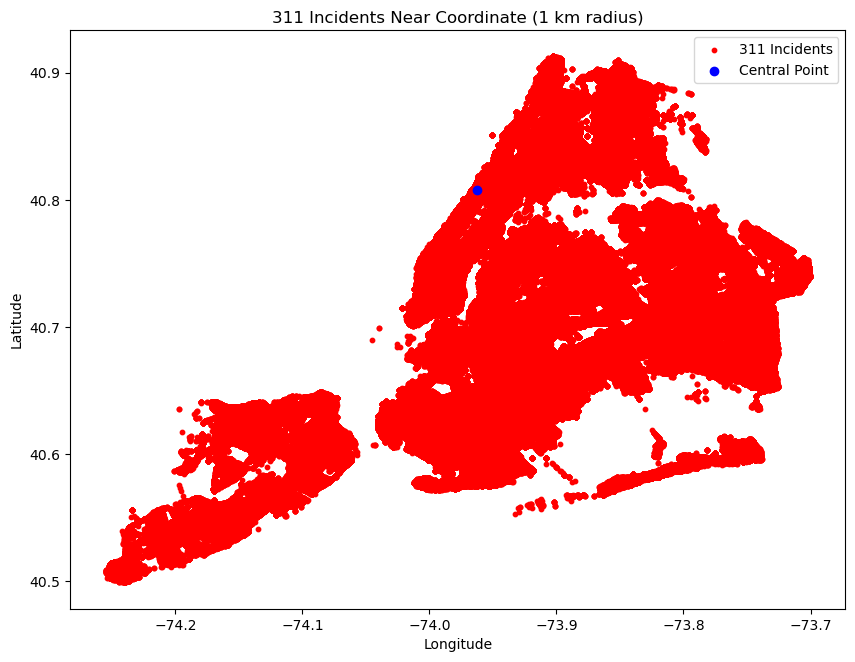

In [119]:
latitude = 40.80737875669467
longitude = -73.96253174434912
radius_meters = 1000
start_date = '2023-01-01'
end_date = '2023-09-30'

plot_311_incidents_near_point(engine, latitude, longitude, radius_meters, start_date, end_date)

Visualization 6

In [124]:
def get_tree_data(engine):
    query = '''
    SELECT latitude, longitude, ST_AsText(ST_SetSRID(ST_MakePoint(longitude::double precision, latitude::double precision), 4326)) AS geometry
    FROM geodf_tree_data;
    '''
    df_trees = pd.read_sql_query(query, engine)

    #Convert
    df_trees['geometry'] = df_trees['geometry'].apply(wkt.loads)

    gdf_trees = gpd.GeoDataFrame(df_trees, geometry='geometry')
    return gdf_trees

In [128]:
def get_new_tree_request_data(engine, start_date='2018-10-01', end_date='2023-09-30'):
    query = '''
    SELECT latitude, longitude, ST_AsText(ST_SetSRID(ST_MakePoint(longitude::double precision, latitude::double precision), 4326)) AS geometry
    FROM geodf_311_data
    WHERE complaint_type = 'New Tree Request' AND
          created_date >= %(start_date)s AND created_date <= %(end_date)s;
    '''
    df_new_tree_requests = pd.read_sql_query(query, engine, params={'start_date': start_date, 'end_date': end_date})

    # Convert
    df_new_tree_requests['geometry'] = df_new_tree_requests['geometry'].apply(wkt.loads)

    gdf_new_tree_requests = gpd.GeoDataFrame(df_new_tree_requests, geometry='geometry')
    return gdf_new_tree_requests

In [129]:
def plot_trees_and_new_tree_requests(engine):
    # Get the data
    trees_gdf = get_tree_data(engine)
    new_tree_requests_gdf = get_new_tree_request_data(engine)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    trees_gdf.plot(ax=ax, markersize=2, color='green', label='Trees')
    new_tree_requests_gdf.plot(ax=ax, markersize=5, color='blue', marker='x', label='New Tree Requests')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Trees and New Tree Requests in NYC (Oct 2018 - Sep 2023)')
    plt.legend()
    plt.show()


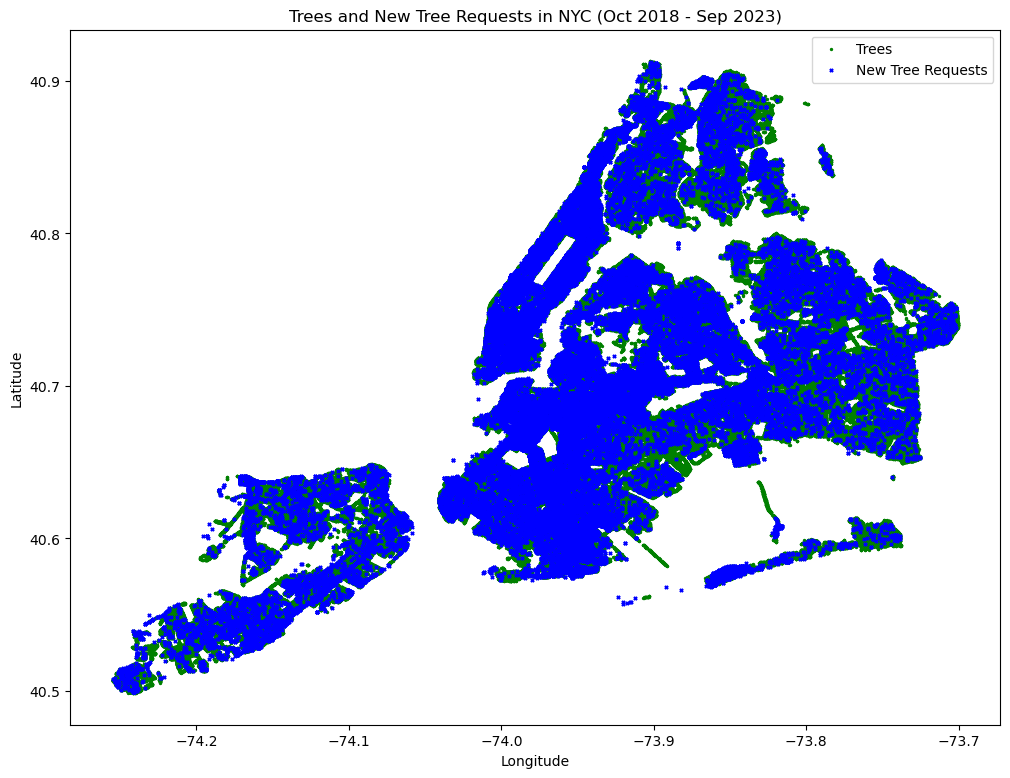

In [130]:
plot_trees_and_new_tree_requests(engine)